In [1]:
import json
import nltk
import os
import string
import unicodedata

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

from nltk.corpus import stopwords
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [2]:
json_dir = Path(r"../data/dvlog_text")
annotations_file = Path(r"../DVlog/dataset/dvlog_labels_v2.csv")
synonyms_file = Path(r"../data/depression_synonyms.json")

In [3]:
# load in the annotation labels
df_annotations = pd.read_csv(annotations_file)
df_annotations.head()

,video_id,label,gender,dataset
0,0,1,f,train
1,1,1,f,test
2,2,1,m,train
3,3,1,m,train
4,4,1,f,test


In [4]:
# load in the synonyms file
with open(synonyms_file) as current_file:
    depri_synonyms = list(json.loads(current_file.read()).get("depression"))

depri_synonyms[:10]

['affect lack',
 'affect unhappy',
 'affects lack',
 'anhedonia',
 'anhedonias',
 'apathetic',
 'apathetic behavior',
 'apathetic behaviour',
 'apathy',
 'cannot see a future']

In [5]:
# loop over each text file and extract the text
text_ref_dict = {}

for json_file in os.listdir(json_dir):
    
    # get the video_id and setup the path to the file
    video_id = int(json_file.split("_")[0])
    json_path = os.path.join(json_dir, json_file)
    
    with open(json_path) as current_file:
        json_dict = json.loads(current_file.read())

    text_ref_dict[video_id] = json_dict["text"]

In [6]:
# put the annotations back into the dataframe
df_annotations["text"] = df_annotations["video_id"].apply(lambda x: text_ref_dict.get(x))
df_annotations.head()

,video_id,label,gender,dataset,text
0,0,1,f,train,So I wanted to come on here and sit down with...
1,1,1,f,test,"Hello guys, it's me again and I'm going to ta..."
2,2,1,m,train,Welcome back to another video today. I'm goin...
3,3,1,m,train,Hi everybody and welcome to and the clouds br...
4,4,1,f,test,"Hey, me and McCrown, me and my hairy hair pit..."


##
train with xgboost and 1 for every word
train with xgboost and 1 for every word and remove certain keywords

In [27]:
# do some preprocessing to shrink the vocabulary (including lemmatization)
def preprocess_string(text: str, stop_words: set = set(stopwords.words("english")), unicode_pattern: str = "NFKD", use_lem: bool=True) -> str:
    text = text.replace("\n", " ").strip()  # Remove newlines and trailing whitespace
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove puctuation with lookup table
    text = text.lower()  # Lowercase
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    text = text.translate(str.maketrans("", "", string.digits))  # Remove all numbers with lookup table
    
    # Remove excess whitespace in between words
    # E.g. the sentence "for 10 days" becomes "for days" instead of "for  days" with two spaces
    text = " ".join(text.split())
    text = unicodedata.normalize(unicode_pattern, text)  # Strip accents from characters
    
    # Lemmatization
    if use_lem:
        lemmanizer = nltk.stem.WordNetLemmatizer()
        text = " ".join([lemmanizer.lemmatize(word) for word in text.split()])

    return text

df_annotations["preprocessed"] = df_annotations["text"].apply(lambda x: preprocess_string(x, use_lem=False))
df_annotations.head()

,video_id,label,gender,dataset,text,preprocessed
0,0,1,f,train,So I wanted to come on here and sit down with...,wanted come sit guys kind talk vent really str...
1,1,1,f,test,"Hello guys, it's me again and I'm going to ta...",hello guys im going talk today survive depress...
2,2,1,m,train,Welcome back to another video today. I'm goin...,welcome back another video today im going expl...
3,3,1,m,train,Hi everybody and welcome to and the clouds br...,hi everybody welcome clouds break time talked ...
4,4,1,f,test,"Hey, me and McCrown, me and my hairy hair pit...",hey mccrown hairy hair pits im mess im mess he...


In [28]:
# get the data subsets
df_train = df_annotations[df_annotations["dataset"] == "train"]
df_test = df_annotations[df_annotations["dataset"] == "test"]
df_val = df_annotations[df_annotations["dataset"] == "val"]

In [29]:
# setup the bag of words model
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(df_train["preprocessed"].to_list())

# retrieve the feature names
feature_names = vectorizer.get_feature_names_out()

# set the count vectorizer to 0 or 1
X_train = X_train.toarray()
X_train = np.where(X_train > 1, 1, X_train)
y_train = df_train["label"].to_list()

In [30]:
# setup the evaluation script
def calculate_performance_measures(y_true, y_pred):

    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

    print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1-score: {fscore}\n--------")

In [31]:
# train a randomforestclassifier
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)

# evaluate the model on the train set
y_pred = clf.predict(X_train)
calculate_performance_measures(y_train, y_pred)

# evaluate the model on the eval set
X_val = vectorizer.fit_transform(df_train["preprocessed"].to_list())


Accuracy: 0.9913494809688581
Precision: 0.991352801465028
Recall: 0.9913494809688581
F1-score: 0.9913481500515241
--------


            importance       std
depression    0.030120  0.104791
student       0.018333  0.056275
depressed     0.016276  0.062887
anxiety       0.015103  0.043347
university    0.014163  0.040686
...                ...       ...
gaviscone     0.000000  0.000000
gay           0.000000  0.000000
gays          0.000000  0.000000
gbk           0.000000  0.000000
zyprex        0.000000  0.000000

[17540 rows x 2 columns]


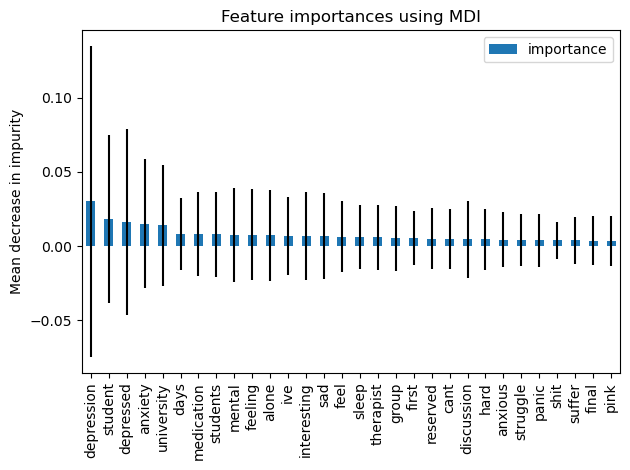

In [34]:
# retrieve the feature importances
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)


# build the dataframe
# forest_importances = pd.Series(importances, index=feature_names)
# forest_importances.sort_values(ascending=False, inplace=True)
forest_importances = [(a, b) for a, b in zip(importances, std)]
df_importances = pd.DataFrame(forest_importances, index=feature_names, columns=["importance", "std"])

# sort based on importance
df_importances.sort_values("importance", ascending=False, inplace=True)
print(df_importances)


fig, ax = plt.subplots()
df_importances[:30].plot.bar(yerr="std", ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [43]:
# remove the 
def filter_synonyms(text: str, synonyms: list):
    for synonym in synonyms:
        if synonym in text:
            text = text.replace(synonym, "")
    return text

# add some extra words
extra_synonyms = ["anxiety", "mental", "sad", "anxious"]
final_synonyms = depri_synonyms.extend(extra_synonyms)

df_annotations["no_synonyms"] = df_annotations["preprocessed"].apply(lambda x: filter_synonyms(x, depri_synonyms))
df_annotations.head()

,video_id,label,gender,dataset,text,preprocessed,no_synonyms
0,0,1,f,train,So I wanted to come on here and sit down with...,wanted come sit guys kind talk vent really str...,wanted come sit guys kind talk vent really str...
1,1,1,f,test,"Hello guys, it's me again and I'm going to ta...",hello guys im going talk today survive depress...,hello guys im going talk today survive based ...
2,2,1,m,train,Welcome back to another video today. I'm goin...,welcome back another video today im going expl...,welcome back another video today im going expl...
3,3,1,m,train,Hi everybody and welcome to and the clouds br...,hi everybody welcome clouds break time talked ...,hi everybody welcome clouds break time talked ...
4,4,1,f,test,"Hey, me and McCrown, me and my hairy hair pit...",hey mccrown hairy hair pits im mess im mess he...,hey mccrown hairy hair pits im mess im mess he...


In [44]:
# get the data subsets
df_train = df_annotations[df_annotations["dataset"] == "train"]
df_test = df_annotations[df_annotations["dataset"] == "test"]
df_val = df_annotations[df_annotations["dataset"] == "val"]

In [50]:
# setup the bag of words model
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(df_train["no_synonyms"].to_list())

# retrieve the feature names
feature_names = vectorizer.get_feature_names_out()

# set the count vectorizer to 0 or 1
X_train = X_train.toarray()
X_train = np.where(X_train > 1, 1, X_train)
y_train = df_train["label"].to_list()

In [51]:
# train a randomforestclassifier
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)

# evaluate the model on the train set
y_pred = clf.predict(X_train)
calculate_performance_measures(y_train, y_pred)

# evaluate the model on the eval set
X_val = vectorizer.fit_transform(df_train["no_synonyms"].to_list())

Accuracy: 0.9844290657439446
Precision: 0.984862930785135
Recall: 0.9844290657439446
F1-score: 0.9844040563940901
--------


            importance       std
feeling       0.015465  0.048265
university    0.010375  0.026511
worse         0.010124  0.028780
medication    0.008260  0.029479
doctor        0.007607  0.026916
...                ...       ...
geneva        0.000000  0.000000
genevieve     0.000000  0.000000
genius        0.000000  0.000000
genre         0.000000  0.000000
zyprex        0.000000  0.000000

[17502 rows x 2 columns]


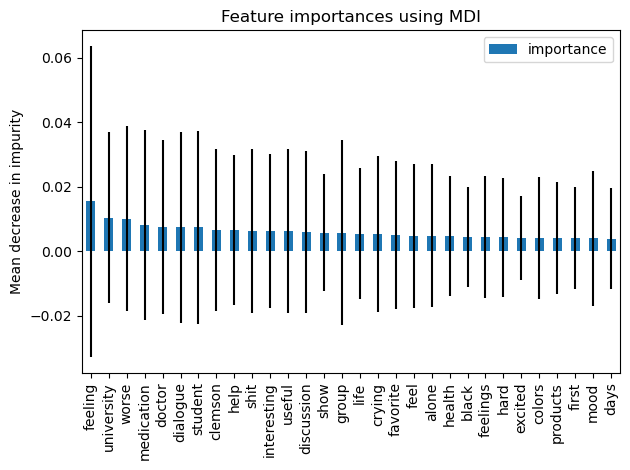

In [52]:
# retrieve the feature importances
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)


# build the dataframe
# forest_importances = pd.Series(importances, index=feature_names)
# forest_importances.sort_values(ascending=False, inplace=True)
forest_importances = [(a, b) for a, b in zip(importances, std)]
df_importances = pd.DataFrame(forest_importances, index=feature_names, columns=["importance", "std"])

# sort based on importance
df_importances.sort_values("importance", ascending=False, inplace=True)
print(df_importances)


fig, ax = plt.subplots()
df_importances[:30].plot.bar(yerr="std", ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()